<a href="https://colab.research.google.com/github/dsrajatsrivastava/python_in_action/blob/Python_Programming/PIP_Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# For visualization
from sklearn.decomposition import PCA


In [35]:
# Sample dataset (replace with actual dataset)
data = pd.read_csv('/content/customer_feedback.csv')


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Feedback  800 non-null    object
 1   Label     800 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [37]:
data['Label'] = LabelEncoder().fit_transform(data['Label'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['Feedback'], data['Label'], test_size=0.2, random_state=42)

# Text preprocessing function (removal of stopwords, punctuation, etc.)
def preprocess_text(text):
    # Tokenize and clean text (you can expand this based on your use case)
    text = text.lower()
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word.isalpha()])

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)


In [38]:
# Create a CountVectorizer to transform text into bag of words
vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()

# Fit a classification model (e.g., Logistic Regression, SVM, etc.)
from sklearn.linear_model import LogisticRegression
classifier_bow = LogisticRegression()
classifier_bow.fit(X_train_bow, y_train)

# Predict the test set
y_pred_bow = classifier_bow.predict(X_test_bow)

# Accuracy Score for BoW
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"BoW Accuracy: {accuracy_bow}")


BoW Accuracy: 0.83125


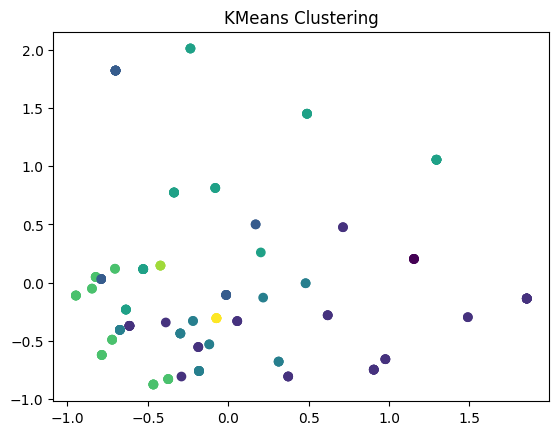

In [39]:
# KMeans Clustering
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X_train_bow)
y_kmeans = kmeans.predict(X_test_bow)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_test_bow)

# Birch Clustering
birch = Birch(n_clusters=8)
y_birch = birch.fit_predict(X_test_bow)

# Visualize Clusters for KMeans
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_bow)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis')
plt.title("KMeans Clustering")
plt.show()


In [40]:
# Load Word2Vec pre-trained embeddings (Gensim)
word2vec_model = api.load('word2vec-google-news-300')

def get_word2vec_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in word2vec_model:
            embeddings.append(word2vec_model[word])
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)

# Transform the text into word embeddings
X_train_w2v = np.array([get_word2vec_embeddings(text) for text in X_train])
X_test_w2v = np.array([get_word2vec_embeddings(text) for text in X_test])

# Fit a classification model (e.g., Logistic Regression, SVM, etc.)
classifier_w2v = LogisticRegression()
classifier_w2v.fit(X_train_w2v, y_train)

# Predict the test set
y_pred_w2v = classifier_w2v.predict(X_test_w2v)

# Accuracy Score for Word2Vec
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
print(f"Word2Vec Accuracy: {accuracy_w2v}")


Word2Vec Accuracy: 0.84375


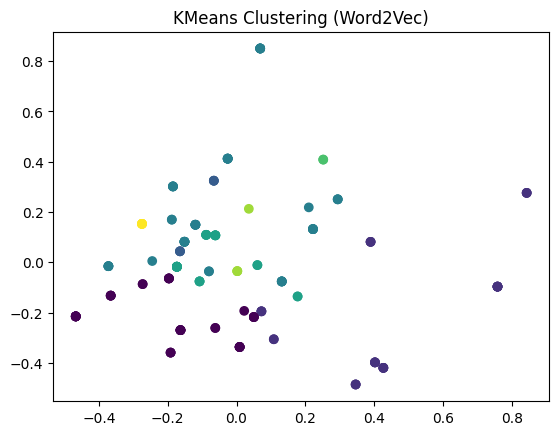

In [41]:
# KMeans Clustering
kmeans_w2v = KMeans(n_clusters=8, random_state=42)
kmeans_w2v.fit(X_train_w2v)
y_kmeans_w2v = kmeans_w2v.predict(X_test_w2v)

# DBSCAN Clustering
dbscan_w2v = DBSCAN(eps=0.5, min_samples=5)
y_dbscan_w2v = dbscan_w2v.fit_predict(X_test_w2v)

# Birch Clustering
birch_w2v = Birch(n_clusters=8)
y_birch_w2v = birch_w2v.fit_predict(X_test_w2v)

# Visualize Clusters for KMeans
X_pca_w2v = pca.fit_transform(X_test_w2v)
plt.scatter(X_pca_w2v[:, 0], X_pca_w2v[:, 1], c=y_kmeans_w2v, cmap='viridis')
plt.title("KMeans Clustering (Word2Vec)")
plt.show()


In [42]:
# Tokenizing the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(8, activation='softmax'))  # 3 output classes

# Compile the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# Predict on the test set
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)

# Accuracy Score for LSTM
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Accuracy: {accuracy_lstm}")


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.1946 - loss: 2.0691 - val_accuracy: 0.6500 - val_loss: 2.0249
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.7330 - loss: 2.0037 - val_accuracy: 0.7937 - val_loss: 1.9262
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.8273 - loss: 1.8750 - val_accuracy: 0.7937 - val_loss: 1.6800
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.7690 - loss: 1.6039 - val_accuracy: 0.7375 - val_loss: 1.2643
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.7552 - loss: 1.2225 - val_accuracy: 0.7937 - val_loss: 0.9499
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
LSTM Accuracy: 0.79375


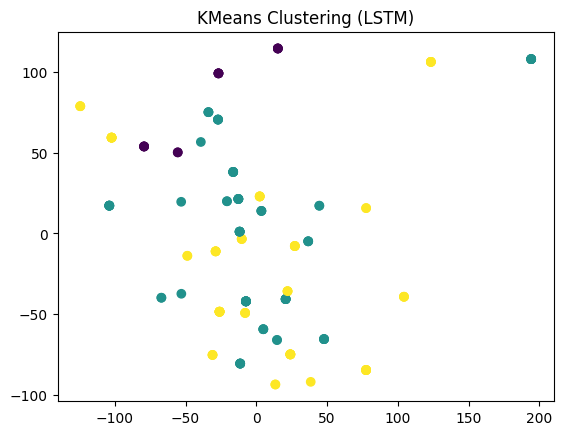

In [43]:
# KMeans Clustering
kmeans_lstm = KMeans(n_clusters=3, random_state=42)
kmeans_lstm.fit(X_train_pad)
y_kmeans_lstm = kmeans_lstm.predict(X_test_pad)

# DBSCAN Clustering
dbscan_lstm = DBSCAN(eps=0.5, min_samples=5)
y_dbscan_lstm = dbscan_lstm.fit_predict(X_test_pad)

# Birch Clustering
birch_lstm = Birch(n_clusters=3)
y_birch_lstm = birch_lstm.fit_predict(X_test_pad)

# Visualize Clusters for KMeans
X_pca_lstm = pca.fit_transform(X_test_pad)
plt.scatter(X_pca_lstm[:, 0], X_pca_lstm[:, 1], c=y_kmeans_lstm, cmap='viridis')
plt.title("KMeans Clustering (LSTM)")
plt.show()


In [44]:
# Saving actual and predicted labels for each model

results = pd.DataFrame({
    'Actual Labels': y_test,
    'BoW Predictions': y_pred_bow,
    'Word2Vec Predictions': y_pred_w2v,
    'LSTM Predictions': y_pred_lstm
})

results.to_csv('sentiment_analysis_results.csv', index=False)


In [45]:
results

,Actual Labels,BoW Predictions,Word2Vec Predictions,LSTM Predictions
696,2,2,2,2
667,7,7,7,7
63,2,2,2,2
533,4,4,4,4
66,4,4,4,4
...,...,...,...,...
589,2,2,2,2
798,6,5,1,5
744,7,7,7,7
513,5,5,5,5


In [51]:
labels = [
    "worst",
    "very bad",
    "bad",
    "average",
    "good",
    "very good",
    "great",
    "excellent"
]


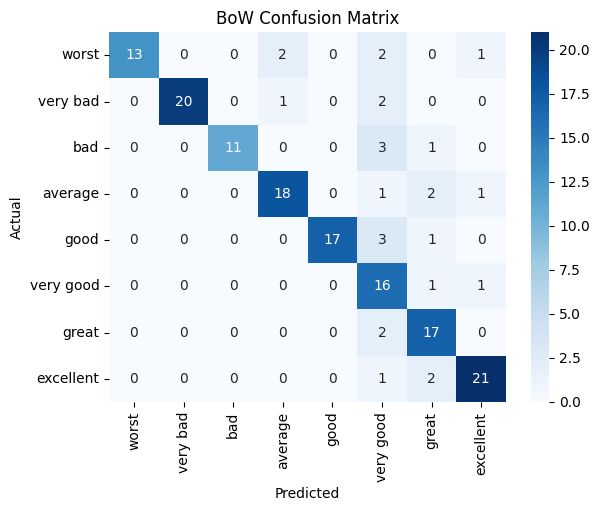

BoW Precision: 0.8744717261904762
BoW Recall: 0.83125
BoW F1 Score: 0.8400985304524511


In [54]:
# Confusion Matrix for BoW
cm_bow = confusion_matrix(y_test, y_pred_bow)
# Plot Confusion Matrix for BoW
sns.heatmap(cm_bow, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("BoW Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1 Score for BoW
precision_bow = precision_score(y_test, y_pred_bow, average='weighted')
recall_bow = recall_score(y_test, y_pred_bow, average='weighted')
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

print(f"BoW Precision: {precision_bow}")
print(f"BoW Recall: {recall_bow}")
print(f"BoW F1 Score: {f1_bow}")


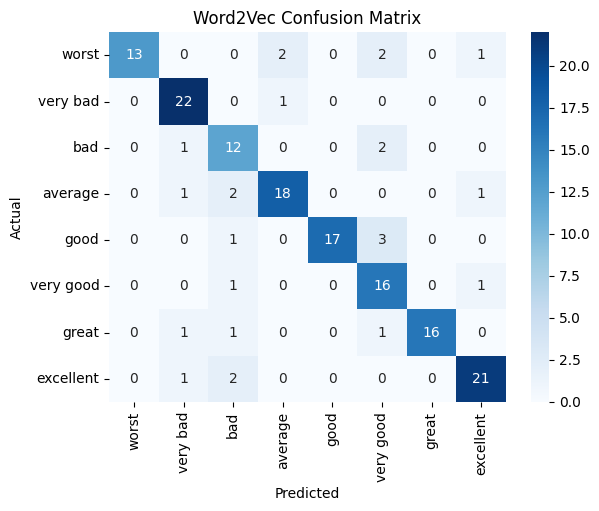

Word2Vec Precision: 0.8674522845575477
Word2Vec Recall: 0.84375
Word2Vec F1 Score: 0.8476991458327715


In [55]:
# Confusion Matrix for Word2Vec
cm_w2v = confusion_matrix(y_test, y_pred_w2v)

# Plot Confusion Matrix for Word2Vec
sns.heatmap(cm_w2v, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Word2Vec Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1 Score for Word2Vec
precision_w2v = precision_score(y_test, y_pred_w2v, average='weighted')
recall_w2v = recall_score(y_test, y_pred_w2v, average='weighted')
f1_w2v = f1_score(y_test, y_pred_w2v, average='weighted')

print(f"Word2Vec Precision: {precision_w2v}")
print(f"Word2Vec Recall: {recall_w2v}")
print(f"Word2Vec F1 Score: {f1_w2v}")


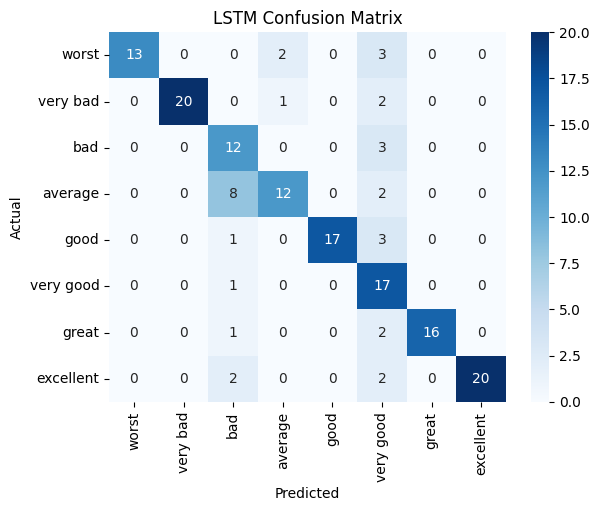

LSTM Precision: 0.8675
LSTM Recall: 0.79375
LSTM F1 Score: 0.8094419259004978


In [57]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot Confusion Matrix for LSTM
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1 Score for LSTM
precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')

print(f"LSTM Precision: {precision_lstm}")
print(f"LSTM Recall: {recall_lstm}")
print(f"LSTM F1 Score: {f1_lstm}")
